In [1]:
import sys
import os
import networkx as nx
import pandas as pd
import numpy as np
import random
random.seed(42)
from tqdm import tqdm

random.seed(42)

sys.path.append(os.path.join(os.getcwd(), '../..'))
from ConuForecast.src.tseries_dataset import TseriesManager
from ConuForecast.src.graph_utils import DBconnector, GraphEngine

In [2]:
conn = DBconnector('172.17.0.1', 5555, 'base-ina', 'postgres', 'postgres')

EVENT = 'sjj-e11Oct19'
MODEL = f'model_{EVENT}'
PRECIP = f'precipitation_{EVENT}'
# ET = '2017-01-01 10:15:00'
ET = '2019-10-11 00:10:00'
ET = '2001-01-01 00:40:00'
ATTRS = {
    'nodes': ['elevation', 'area', 'imperv', 'slope','rainfall', 'depth_above_invert'],
    'edges': ['flow_rate', 'flow_velocity']
    }

In [3]:
ina_sims = GraphEngine(model=MODEL, event=EVENT, precip=PRECIP, conn=conn)

In [4]:
[event[0] for event in conn.query('SELECT event_id FROM events')]

['test',
 '007',
 'sjj_157',
 'sjj-38',
 'sjj-160',
 'sjj-47',
 'sjj-041',
 'sjj-044',
 'sjj-092',
 'sjj-095',
 'sjj-101',
 'sjj-146',
 'sjj-149',
 'sjj-152',
 'sjj-155',
 'sjj-e11Oct19',
 'sjj-e13Jun19',
 'sjj-e17Oct19',
 'sjj-e30Dic19',
 'sjj-e30Sep19']

In [81]:

ATTRS = {
    'nodes': ['rainfall', 'depth_above_invert'],
    'edges': ['flow_rate', 'flow_velocity']
    }

conu_basin_tseries = TseriesManager(model=MODEL, event=EVENT, precip=PRECIP, conn=conn)

## Pre-Processing

In [82]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [83]:
def list_diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

In [84]:
def build_dataset(n_train_nodes, features, timesteps):

    sets = {
        'train': {},
        'test': {}
    }

    sets['train']['n_nodes'] = n_train_nodes
    sets['train']['nodes'] = random.sample(conu_basin_tseries.get_nodes(), n_train_nodes)
    
    sets['test']['nodes'] = list_diff(conu_basin_tseries.get_nodes(), sets['train']['nodes'])[:10]
    sets['test']['n_nodes'] = len(sets['test']['nodes'])

    series_size = len(conu_basin_tseries.get_time_steps()[0])
    n_features = len(features) - 1
    timesteps = timesteps

    datasets = []

    for dataset in sets.keys():
        agg_df_X = []
        agg_df_y = []

        for node in tqdm(sets[dataset]['nodes']):
            node_seq = conu_basin_tseries.timeseries(
                node,
                features,
                datetime_index=False,
                peak_data=False
                )

            node_seq = node_seq.to_numpy().reshape(series_size, n_features + 1)

            X_node_seq, y_node_seq = split_sequences(node_seq, timesteps)

            agg_df_X.append(X_node_seq[:,:,:-1])
            agg_df_y.append(y_node_seq)

        X = np.array(agg_df_X).reshape(sets[dataset]['n_nodes'] * (series_size - timesteps),timesteps, n_features)
        y = np.array(agg_df_y).reshape(sets[dataset]['n_nodes'] * (series_size - timesteps), 1)

        sets[dataset]['X'] = X
        sets[dataset]['y'] = y

    return sets

In [85]:
# X_train, X_test, y_train, y_test =
a = build_dataset(100, ATTRS['nodes'], 8)

100%|██████████| 10/10 [00:00<00:00, 25.44it/s]


In [94]:
X_train = a['train']['X']
y_train = a['train']['y']
X_test = a['test']['X']
y_test = a['test']['y']

In [98]:
y_train.shape
# y_train[:15]

(56800, 1)

In [96]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# # split into train and test sets
# values = agg_df#.values
# batch_size = len(conu_basin_tseries.get_time_steps()[0])
# n_train_hours = batch_size * round(0.9 * num_nodes,0)
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]

# # split into input and outputs
# tseries_timesteps = 3
# train_X, train_y = split_sequence(train, tseries_timesteps)
# test_X, test_y = split_sequence(test, tseries_timesteps)

# # reshape input to be 3D [samples, timesteps, features]
# n_features = 1
# train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# params
timesteps = 8
series_size = len(conu_basin_tseries.get_time_steps()[0])
n_features = len(ATTRS['nodes']) - 1

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, n_features)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(
    X_train, y_train,
     epochs=4,
     batch_size=series_size,
     validation_data=(X_test, y_test),
     verbose=1, 
     shuffle=False
     )

Epoch 1/4


Exception ignored in: <function tqdm.__del__ at 0x7f39eb15ef80>
Traceback (most recent call last):
  File "/opt/conda/envs/conuforecast-cpu/lib/python3.7/site-packages/tqdm/std.py", line 1133, in __del__
    def __del__(self):
KeyboardInterrupt


99/99 [==============================] - 9s 30ms/step - loss: 0.0416 - val_loss: 0.0304
Epoch 2/4
99/99 [==============================] - 2s 23ms/step - loss: 0.0346 - val_loss: 0.0234
Epoch 3/4
99/99 [==============================] - 2s 23ms/step - loss: 0.0311 - val_loss: 0.0221
Epoch 4/4
68/99 [===================>..........] - ETA: 0s - loss: 0.0303

KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
n_time_steps = len(conu_basin_tseries.get_time_steps())

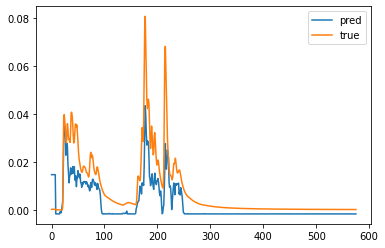

In [26]:
n = 422

plt.plot(model.predict(X_test[n*576:(n+1)*576]), label='pred')
plt.plot(y_test[n*576:(n+1)*576], label='true')
plt.legend()
plt.show()

In [28]:
model.save('../../ConuForecast/models/baseline_model')

INFO:tensorflow:Assets written to: ../../ConuForecast/models/baseline_model/assets
INFO:tensorflow:Assets written to: ../../ConuForecast/models/baseline_model/assets


In [44]:
import pickle

def save_obj(obj, name ):
    with open('../../data/processed/objs/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('../../data/processed/objs/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [43]:
save_obj(a, 'sjj-e11Oct19__8')

FileNotFoundError: [Errno 2] No such file or directory: 'obj/sjj-e11Oct19__8.pkl'

In [6]:
data = conu_basin_tseries.tseries_for_superv_learning(
    'NODO369',
    ATTRS['nodes'],
    n_in=3,
    n_out=3
    ).values
data

array([], shape=(0, 7), dtype=float32)

In [36]:
y_pred = [model.predict_on_batch(i.reshape((1,1,6)))[0][0] for i in data.reshape((1,287,6))[0]]

ValueError: cannot reshape array of size 0 into shape (1,287,6)

In [37]:
y_true = conu_basin_tseries.tseries_for_superv_learning(
    'NODOOUT1',
    ATTRS['nodes']
    ).iloc[:,-1].values

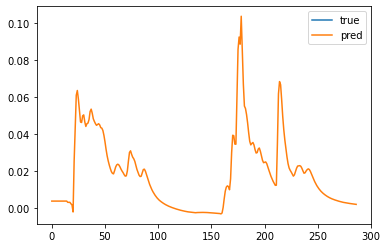

In [38]:
from matplotlib import pyplot

pyplot.plot(y_true, label='true')
pyplot.plot(y_pred, label='pred')
pyplot.legend()
pyplot.show()

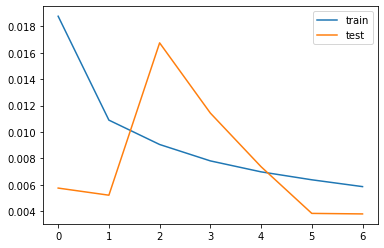

ValueError: Error when checking input: expected lstm_3_input to have 3 dimensions, but got array with shape (435000, 6)

In [18]:
from matplotlib import pyplot

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

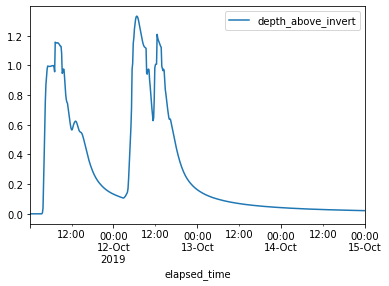

In [17]:
pd.DataFrame(b).plot()

In [8]:
l = []
for node in conu_basin_tseries.get_nodes()[20:40]:
    result = conu_basin_tseries.inp_tseries_rainfall(
        node,
        ['area', 'slope', 'imperv', 'rainfall'],
        )
    if result != None:
        l.append(result)

In [9]:
pd.DataFrame(l[0])

,subcatchment_id,outlet,area,imperv,width,slope,curb_len,elapsed_time,rainfall,format
0,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-11 00:00:00,0.00,CUMULATIVE
1,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-11 00:10:00,0.00,CUMULATIVE
2,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-11 00:20:00,0.00,CUMULATIVE
3,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-11 00:30:00,0.00,CUMULATIVE
4,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-11 00:40:00,0.00,CUMULATIVE
...,...,...,...,...,...,...,...,...,...,...
284,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-12 23:20:00,112.89,CUMULATIVE
285,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-12 23:30:00,112.89,CUMULATIVE
286,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-12 23:40:00,112.89,CUMULATIVE
287,CUENCA8475,NODO10014,0.213,68.0,92.67,1.167,46.152,2019-10-12 23:50:00,112.89,CUMULATIVE


<AxesSubplot:>

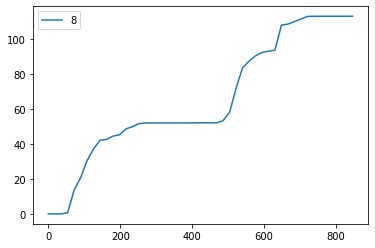

In [26]:
import pandas as pd
import datatable as dt

a = pd.DataFrame(l)

a[a[1] == 'NODO10014'][[8]].plot()

In [37]:
l = []
for node in conu_basin_tseries.get_nodes()[20:40]:
    result = conu_basin_tseries.timeseries(
        item=node,
        var=['depth_above_invert']
        )
    l.append(result)

In [40]:
pd.concat([df for df in l])

,node_id,depth_above_invert
elapsed_time,,
2019-10-11 00:10:00,NODO10014,0.000000
2019-10-11 00:20:00,NODO10014,0.000000
2019-10-11 00:30:00,NODO10014,0.000000
2019-10-11 00:40:00,NODO10014,0.000000
2019-10-11 00:50:00,NODO10014,0.000000
...,...,...
2019-10-14 23:20:00,NODO10031,0.000953
2019-10-14 23:30:00,NODO10031,0.000949
2019-10-14 23:40:00,NODO10031,0.000945


<AxesSubplot:xlabel='elapsed_time'>

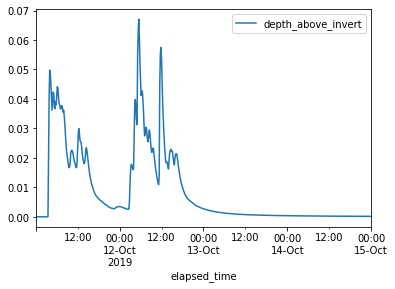

In [41]:
l[0].plot()